## Import Library

In [ ]:
import tensorflow as tf
import seaborn as sns
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import sklearn.preprocessing
from sklearn.metrics import r2_score
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, mean_squared_error
from tensorflow.keras.callbacks import EarlyStopping
from keras.layers import Dense,Dropout,SimpleRNN,LSTM,GRU
from keras.models import Sequential
from tensorflow import keras
from tabulate import tabulate
import torch
import torch.nn as nn
from torch.utils.data import Dataset

In [ ]:
from google.colab import files
uploaded = files.upload()

Saving Bali 2015 - 2022.csv to Bali 2015 - 2022.csv


## LSTM

Processing Data

In [ ]:
data_lstm = pd.read_csv('Bali 2015 - 2022.csv')

# print out sample dataset
print(len(data_lstm))
data_lstm.head()

108


,datetime,total_visitor,total_accomodation
0,1/1/2014,279257,16495
1,2/1/2014,275795,17221
2,3/1/2014,276573,17330
3,4/1/2014,280096,17737
4,5/1/2014,286033,18836


In [ ]:
data_real = data_lstm.copy()

In [ ]:
data_lstm.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 108 entries, 0 to 107
Data columns (total 3 columns):
 #   Column              Non-Null Count  Dtype 
---  ------              --------------  ----- 
 0   datetime            108 non-null    object
 1   total_visitor       108 non-null    int64 
 2   total_accomodation  108 non-null    int64 
dtypes: int64(2), object(1)
memory usage: 2.7+ KB


In [ ]:
# # set data index as datetime column
# data_lstm.index = pd.to_datetime(data_lstm.datetime)

train_datetime = pd.to_datetime(data_lstm.datetime)
data_lstm = data_lstm.set_index('datetime')
required_cols = ['total_visitor', 'total_accomodation']
data_lstm = data_lstm[required_cols]
data_lstm.head()


,total_visitor,total_accomodation
datetime,,
1/1/2014,279257,16495
2/1/2014,275795,17221
3/1/2014,276573,17330
4/1/2014,280096,17737
5/1/2014,286033,18836


In [ ]:
# check number of nan values in dataframe
data_lstm.isna().sum()

total_visitor         0
total_accomodation    0
dtype: int64

In [ ]:
input_col = list(data_lstm)[0:3]
print(input_col)

['total_visitor', 'total_accomodation']


In [ ]:
data_for_training = data_lstm[input_col]

In [ ]:
# Normalize the data
scaler = MinMaxScaler()
scaler = scaler.fit(data_for_training)
scaled_data_train = scaler.transform(data_for_training)

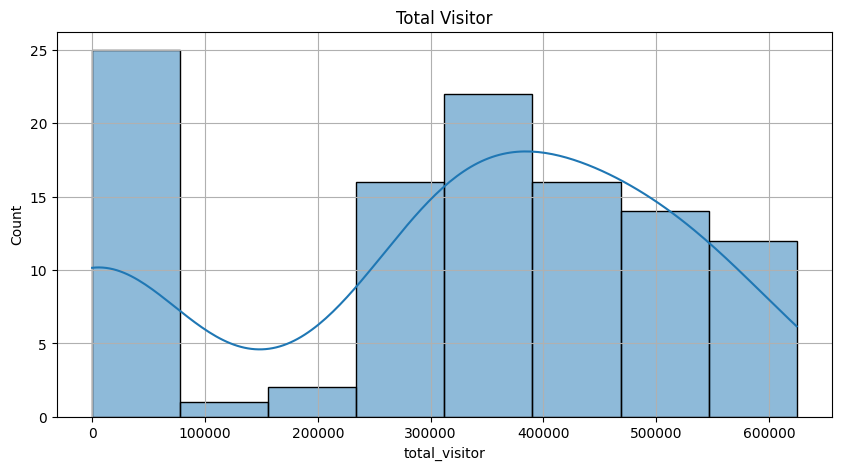

In [ ]:
# plot to see the total visitor varience
plt.figure(figsize=(10, 5))
sns.histplot(data_lstm['total_visitor'], kde=True)
plt.title("Total Visitor")
plt.grid()
plt.show()

###Skenario 1 (80% Train - 20% Test)

In [ ]:
# Define sequence length and features
sequence_length = 12  # Karena data terdiri dari data perbulan dalam satu tahun
num_features = len(data_lstm.columns)

# Create sequences and corresponding labels
sequences = []
labels = []
for i in range(len(scaled_data_train) - sequence_length):
    seq = scaled_data_train[i:i+sequence_length]
    label = scaled_data_train[i+sequence_length][1]
    sequences.append(seq)
    labels.append(label)

# Convert to numpy arrays
sequences = np.array(sequences)
labels = np.array(labels)

# Split into train and test sets
train_x, test_x, train_y, test_y = train_test_split(sequences,labels, test_size=0.2)

print("Train X shape:", train_x.shape)
print("Train Y shape:", train_y.shape)
print("Test X shape:", test_x.shape)
print("Test Y shape:", test_y.shape)

Train X shape: (76, 12, 2)
Train Y shape: (76,)
Test X shape: (20, 12, 2)
Test Y shape: (20,)


In [ ]:
# Create the LSTM model
model = Sequential()

# Add LSTM layers with dropout
model.add(LSTM(units=256, activation = 'tanh', input_shape=(train_x.shape[1], train_x.shape[2]), return_sequences=True))
model.add(Dropout(0.2))

model.add(LSTM(units=128, activation = 'tanh', return_sequences=True))
model.add(Dropout(0.2))

model.add(LSTM(units=64, activation = 'tanh', return_sequences=False))

# Add a dense output layer
model.add(Dense(units=1))

# Compile the model
model.compile(optimizer='adam', loss='mean_squared_error')

In [ ]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 12, 256)           265216    
                                                                 
 dropout (Dropout)           (None, 12, 256)           0         
                                                                 
 lstm_1 (LSTM)               (None, 12, 128)           197120    
                                                                 
 dropout_1 (Dropout)         (None, 12, 128)           0         
                                                                 
 lstm_2 (LSTM)               (None, 64)                49408     
                                                                 
 dense (Dense)               (None, 1)                 65        
                                                                 
Total params: 511809 (1.95 MB)
Trainable params: 511809 

In [ ]:
# Define callbacks
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

# Train the model
history = model.fit(
    train_x, train_y,
    epochs=128,
    batch_size=16,
    validation_split=0.2,  # Use part of the training data as validation
    callbacks=[early_stopping]
)

Epoch 1/128
4/4 [==============================] - 0s 72ms/step - loss: 4.6238e-04 - val_loss: 2.6537e-04
Epoch 2/128
4/4 [==============================] - 0s 65ms/step - loss: 5.0420e-04 - val_loss: 6.7631e-04
Epoch 3/128
4/4 [==============================] - 0s 62ms/step - loss: 5.7620e-04 - val_loss: 4.3124e-04
Epoch 4/128
4/4 [==============================] - 0s 63ms/step - loss: 4.4814e-04 - val_loss: 3.9628e-04
Epoch 5/128
4/4 [==============================] - 0s 73ms/step - loss: 3.1308e-04 - val_loss: 3.1072e-04
Epoch 6/128
4/4 [==============================] - 0s 116ms/step - loss: 5.0611e-04 - val_loss: 2.6568e-04


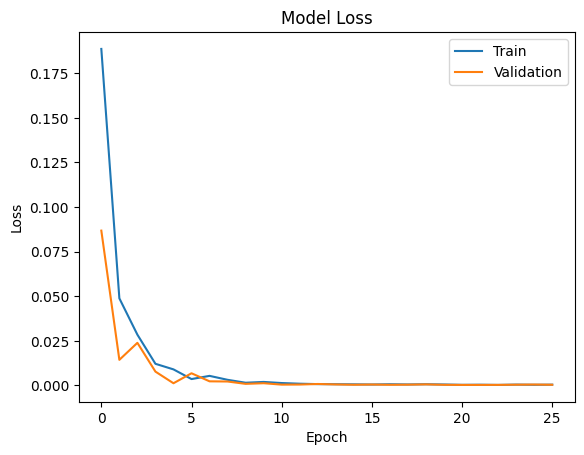

In [ ]:
# Plot training & validation loss values
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(['Train', 'Validation'], loc='upper right')
plt.show()

In [ ]:
# Predict for 12 month afterwards
n_past = 1
n_month_for_prediction = 12
predict_period_month = pd.date_range(list(train_datetime)[-n_past], periods=n_month_for_prediction, freq='M').tolist()
print(predict_period_month)

[Timestamp('2022-12-31 00:00:00', freq='M'), Timestamp('2023-01-31 00:00:00', freq='M'), Timestamp('2023-02-28 00:00:00', freq='M'), Timestamp('2023-03-31 00:00:00', freq='M'), Timestamp('2023-04-30 00:00:00', freq='M'), Timestamp('2023-05-31 00:00:00', freq='M'), Timestamp('2023-06-30 00:00:00', freq='M'), Timestamp('2023-07-31 00:00:00', freq='M'), Timestamp('2023-08-31 00:00:00', freq='M'), Timestamp('2023-09-30 00:00:00', freq='M'), Timestamp('2023-10-31 00:00:00', freq='M'), Timestamp('2023-11-30 00:00:00', freq='M')]


In [ ]:
prediction = model.predict(train_x[-n_month_for_prediction:])
mse = mean_squared_error(train_y[-n_month_for_prediction:], prediction)
fmape = np.mean(np.abs((mse) / prediction)) * 100
mape = f"{(fmape*100):.2f}%"
mae = np.mean(np.abs((mse) /prediction))
r2_1 = r2_score(train_y[-n_month_for_prediction:], prediction)
print("MSE:", mse)
print("MAPE:", mape)
print("MAE:", mae)
print("r-scores:", r2_1)


1/1 [==============================] - 0s 55ms/step
MSE: 0.00017265542556837556
MAPE: 4.08%
MAE: 0.0004081348
r-scores: 0.996651837366195


In [ ]:
prediction_copies = np.repeat(prediction, data_for_training.shape[1], axis=-1)
y_pred_future = scaler.inverse_transform(prediction_copies)[:,0]

<ipython-input-34-592d2a871f4e>:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  original['datetime'] = pd.to_datetime(original['datetime'])


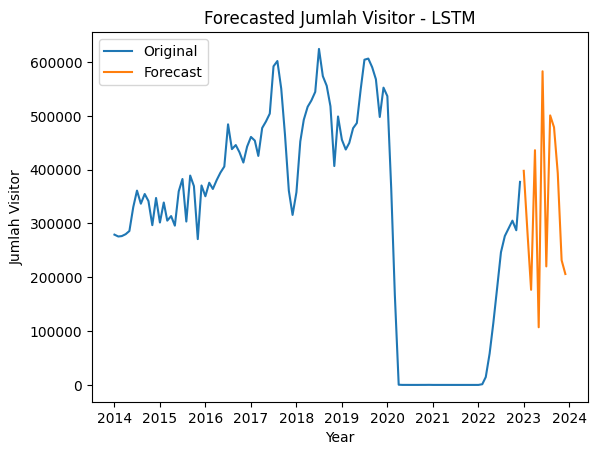

╒═════════════════════╤══════════════╕
│ Date                │   Prediction │
╞═════════════════════╪══════════════╡
│ 2023-01-01 00:00:00 │       397834 │
├─────────────────────┼──────────────┤
│ 2023-02-01 00:00:00 │       279067 │
├─────────────────────┼──────────────┤
│ 2023-03-01 00:00:00 │       176758 │
├─────────────────────┼──────────────┤
│ 2023-04-01 00:00:00 │       436148 │
├─────────────────────┼──────────────┤
│ 2023-05-01 00:00:00 │       107134 │
├─────────────────────┼──────────────┤
│ 2023-06-01 00:00:00 │       582810 │
├─────────────────────┼──────────────┤
│ 2023-07-01 00:00:00 │       220216 │
├─────────────────────┼──────────────┤
│ 2023-08-01 00:00:00 │       500872 │
├─────────────────────┼──────────────┤
│ 2023-09-01 00:00:00 │       478743 │
├─────────────────────┼──────────────┤
│ 2023-10-01 00:00:00 │       393534 │
├─────────────────────┼──────────────┤
│ 2023-11-01 00:00:00 │       231728 │
├─────────────────────┼──────────────┤
│ 2023-12-01 00:00:00 │  

In [ ]:
forecast_dates = []

for time_i in predict_period_month:
    forecast_dates.append(time_i.date())

df_forecast = pd.DataFrame({'Date': forecast_dates, 'total_visitor': y_pred_future})
df_forecast['Date'] = pd.to_datetime(df_forecast['Date'])

# Assuming 'original' contains the original data with 'datetime' and 'total_visitor' columns
original = data_real[['datetime', 'total_visitor']]
original['datetime'] = pd.to_datetime(original['datetime'])
original = original.loc[original['datetime'] >= '2014-01-01']


sns.lineplot(data=original, x='datetime', y='total_visitor', label='Original')
sns.lineplot(data=df_forecast, x='Date', y='total_visitor', label='Forecast')

plt.xlabel('Year')
plt.ylabel('Jumlah Visitor')
plt.title('Forecasted Jumlah Visitor - LSTM')
plt.legend()
plt.show()

# Generate the forecast dates from January 2023 to December 2023
forecast_dates_1 = pd.date_range(start='2023-01-01', end='2023-12-01', freq='MS')

# Create a list of forecast dates and prediction values
data = list(zip(forecast_dates_1, y_pred_future))

# Create a list of headers for the table
headers = ['Date', 'Prediction']
table = tabulate(data, headers=headers, tablefmt='fancy_grid')
# Print the table
print(table)

###Skenario 2 (70% Train - 30% Test)

In [ ]:
# Define sequence length and features
sequence_length2_lstm = 12  # Karena data terdiri dari data perbulan dalam satu tahun
num_features2_lstm = len(data_lstm.columns)

# Create sequences and corresponding labels
sequences2_lstm = []
labels2_lstm = []
for i in range(len(scaled_data_train) - sequence_length):
    seq = scaled_data_train[i:i+sequence_length]
    label = scaled_data_train[i+sequence_length][1]
    sequences2_lstm.append(seq)
    labels2_lstm.append(label)

# Convert to numpy arrays
sequences2_lstm = np.array(sequences2_lstm)
labels2_lstm = np.array(labels2_lstm)

# Split into train and test sets
train_x2_lstm, test_x2_lstm, train_y2_lstm, test_y2_lstm = train_test_split(sequences2_lstm,labels2_lstm, test_size=0.3)

print("Train X shape:", train_x2_lstm.shape)
print("Train Y shape:", train_y2_lstm.shape)
print("Test X shape:", test_x2_lstm.shape)
print("Test Y shape:", test_y2_lstm.shape)

Train X shape: (67, 12, 2)
Train Y shape: (67,)
Test X shape: (29, 12, 2)
Test Y shape: (29,)


In [ ]:
# Create the LSTM model
model2_lstm = Sequential()

# Add LSTM layers with dropout
model2_lstm.add(LSTM(units=256, activation = 'tanh', input_shape=(train_x2_lstm.shape[1], train_x2_lstm.shape[2]), return_sequences=True))
model2_lstm.add(Dropout(0.3))

model2_lstm.add(LSTM(units=128, activation = 'tanh', return_sequences=True))
model2_lstm.add(Dropout(0.3))

model2_lstm.add(LSTM(units=64, activation = 'tanh', return_sequences=False))

# Add a dense output layer
model2_lstm.add(Dense(units=1))

# Compile the model
model2_lstm.compile(optimizer='adam', loss='mean_squared_error')

In [ ]:
model2_lstm.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_3 (LSTM)               (None, 12, 256)           265216    
                                                                 
 dropout_2 (Dropout)         (None, 12, 256)           0         
                                                                 
 lstm_4 (LSTM)               (None, 12, 128)           197120    
                                                                 
 dropout_3 (Dropout)         (None, 12, 128)           0         
                                                                 
 lstm_5 (LSTM)               (None, 64)                49408     
                                                                 
 dense_1 (Dense)             (None, 1)                 65        
                                                                 
Total params: 511809 (1.95 MB)
Trainable params: 51180

In [ ]:
# Define callbacks
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

# Train the model
history2_lstm = model2_lstm.fit(
    train_x2_lstm, train_y2_lstm,
    epochs=128,
    batch_size=16,
    validation_split=0.3,  # Use part of the training data as validation
    callbacks=[early_stopping]
)

Epoch 1/128
3/3 [==============================] - 8s 849ms/step - loss: 0.2260 - val_loss: 0.0746
Epoch 2/128
3/3 [==============================] - 0s 78ms/step - loss: 0.0633 - val_loss: 0.0288
Epoch 3/128
3/3 [==============================] - 0s 79ms/step - loss: 0.0207 - val_loss: 0.0182
Epoch 4/128
3/3 [==============================] - 0s 83ms/step - loss: 0.0092 - val_loss: 0.0071
Epoch 5/128
3/3 [==============================] - 0s 72ms/step - loss: 0.0101 - val_loss: 0.0087
Epoch 6/128
3/3 [==============================] - 0s 72ms/step - loss: 0.0038 - val_loss: 0.0046
Epoch 7/128
3/3 [==============================] - 0s 80ms/step - loss: 0.0043 - val_loss: 6.9715e-04
Epoch 8/128
3/3 [==============================] - 0s 71ms/step - loss: 0.0025 - val_loss: 0.0027
Epoch 9/128
3/3 [==============================] - 0s 77ms/step - loss: 0.0034 - val_loss: 0.0019
Epoch 10/128
3/3 [==============================] - 0s 73ms/step - loss: 0.0033 - val_loss: 0.0021
Epoch 11/128
3

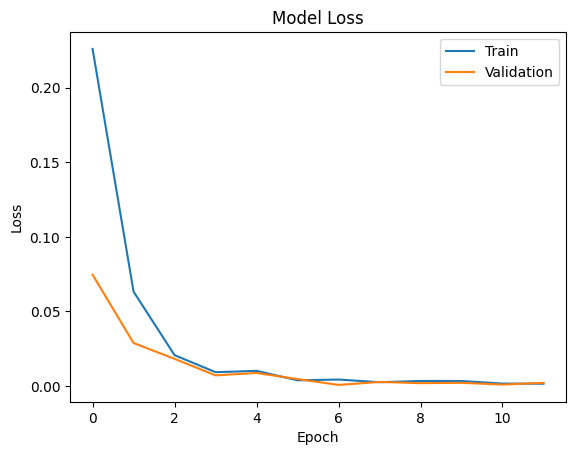

In [ ]:
# Plot training & validation loss values
plt.plot(history2_lstm.history['loss'])
plt.plot(history2_lstm.history['val_loss'])
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(['Train', 'Validation'], loc='upper right')
plt.show()

In [ ]:
# Predict for 12 month afterwards
n_past2_lstm = 1
n_month_for_prediction2_lstm = 12
predict_period_month2_lstm = pd.date_range(list(train_datetime)[-n_past], periods=n_month_for_prediction2_lstm, freq='M').tolist()
print(predict_period_month2_lstm)

[Timestamp('2022-12-31 00:00:00', freq='M'), Timestamp('2023-01-31 00:00:00', freq='M'), Timestamp('2023-02-28 00:00:00', freq='M'), Timestamp('2023-03-31 00:00:00', freq='M'), Timestamp('2023-04-30 00:00:00', freq='M'), Timestamp('2023-05-31 00:00:00', freq='M'), Timestamp('2023-06-30 00:00:00', freq='M'), Timestamp('2023-07-31 00:00:00', freq='M'), Timestamp('2023-08-31 00:00:00', freq='M'), Timestamp('2023-09-30 00:00:00', freq='M'), Timestamp('2023-10-31 00:00:00', freq='M'), Timestamp('2023-11-30 00:00:00', freq='M')]


In [ ]:
# Print the error metrics

prediction2_lstm = model.predict(train_x2_lstm[-n_month_for_prediction:])
mse2_lstm = mean_squared_error(train_y2_lstm[-n_month_for_prediction:], prediction2_lstm)
fmape = np.mean(np.abs((mse2_lstm) / prediction2_lstm)) * 100
mape2_lstm = f"{(fmape*100):.2f}%"
mae2_lstm = np.mean(np.abs((mse) / prediction2_lstm))
r2_2_lstm = r2_score(train_y2_lstm[-n_month_for_prediction:], prediction2_lstm)
print("MSE:", mse2_lstm)
print("MAPE:", mape2_lstm)
print("MAE:", mae2_lstm)
print("r-scores:", r2_2_lstm)


1/1 [==============================] - 0s 193ms/step
MSE: 0.0001804385414467377
MAPE: 6.44%
MAE: 0.0006441854
r-scores: 0.9976826736127211


In [ ]:
prediction_copies2_lstm = np.repeat(prediction2_lstm, data_for_training.shape[1], axis=-1)
y_pred_future2_lstm = scaler.inverse_transform(prediction_copies2_lstm)[:,0]

<ipython-input-54-444f5de07cee>:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  original['datetime'] = pd.to_datetime(original['datetime'])


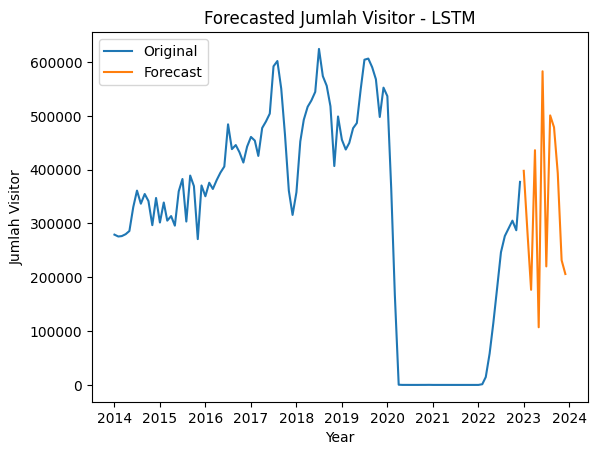

╒═════════════════════╤══════════════╕
│ Date                │   Prediction │
╞═════════════════════╪══════════════╡
│ 2023-01-01 00:00:00 │     524505   │
├─────────────────────┼──────────────┤
│ 2023-02-01 00:00:00 │     589882   │
├─────────────────────┼──────────────┤
│ 2023-03-01 00:00:00 │     272408   │
├─────────────────────┼──────────────┤
│ 2023-04-01 00:00:00 │     107134   │
├─────────────────────┼──────────────┤
│ 2023-05-01 00:00:00 │     265824   │
├─────────────────────┼──────────────┤
│ 2023-06-01 00:00:00 │     339114   │
├─────────────────────┼──────────────┤
│ 2023-07-01 00:00:00 │     112798   │
├─────────────────────┼──────────────┤
│ 2023-08-01 00:00:00 │      64262.7 │
├─────────────────────┼──────────────┤
│ 2023-09-01 00:00:00 │     388266   │
├─────────────────────┼──────────────┤
│ 2023-10-01 00:00:00 │      74023.2 │
├─────────────────────┼──────────────┤
│ 2023-11-01 00:00:00 │     529463   │
├─────────────────────┼──────────────┤
│ 2023-12-01 00:00:00 │  

In [ ]:
forecast_dates2_lstm = []

for time_i in predict_period_month:
    forecast_dates2_lstm.append(time_i.date())

df_forecast2_lstm = pd.DataFrame({'Date': forecast_dates2_lstm, 'total_visitor': y_pred_future2_lstm})
df_forecast2_lstm['Date'] = pd.to_datetime(df_forecast2_lstm['Date'])

# Assuming 'original' contains the original data with 'datetime' and 'total_visitor' columns
original = data_real[['datetime', 'total_visitor']]
original['datetime'] = pd.to_datetime(original['datetime'])
original = original.loc[original['datetime'] >= '2014-01-01']

sns.lineplot(data=original, x='datetime', y='total_visitor', label='Original')
sns.lineplot(data=df_forecast, x='Date', y='total_visitor', label='Forecast')

plt.xlabel('Year')
plt.ylabel('Jumlah Visitor')
plt.title('Forecasted Jumlah Visitor - LSTM')
plt.legend()
plt.show()

# Generate the forecast dates from January 2023 to December 2023
forecast_dates2_lstm = pd.date_range(start='2023-01-01', end='2023-12-01', freq='MS')

# Create a list of forecast dates and prediction values
data = list(zip(forecast_dates2_lstm, y_pred_future2_lstm))

# Create a list of headers for the table
headers = ['Date', 'Prediction']
table2_lstm = tabulate(data, headers=headers, tablefmt='fancy_grid')
# Print the table
print(table2_lstm)

###Skenario 3 (60% Train - 40% Test)

In [ ]:
# Define sequence length and features
sequence_length3_lstm = 12  # Karena data terdiri dari data perbulan dalam satu tahun
num_features3_lstm = len(data_lstm.columns)

# Create sequences and corresponding labels
sequences3_lstm = []
labels3_lstm = []
for i in range(len(scaled_data_train) - sequence_length):
    seq = scaled_data_train[i:i+sequence_length]
    label = scaled_data_train[i+sequence_length][1]
    sequences3_lstm.append(seq)
    labels3_lstm.append(label)

# Convert to numpy arrays
sequences3_lstm = np.array(sequences3_lstm)
labels3_lstm = np.array(labels3_lstm)

# Split into train and test sets
train_x3_lstm, test_x3_lstm, train_y3_lstm, test_y3_lstm = train_test_split(sequences3_lstm,labels3_lstm, test_size=0.4)

print("Train X shape:", train_x3_lstm.shape)
print("Train Y shape:", train_y3_lstm.shape)
print("Test X shape:", test_x3_lstm.shape)
print("Test Y shape:", test_y3_lstm.shape)

Train X shape: (57, 12, 2)
Train Y shape: (57,)
Test X shape: (39, 12, 2)
Test Y shape: (39,)


In [ ]:
# Create the LSTM model
model3_lstm = Sequential()

# Add LSTM layers with dropout
model3_lstm.add(LSTM(units=256, activation = 'tanh', input_shape=(train_x3_lstm.shape[1], train_x3_lstm.shape[2]), return_sequences=True))
model3_lstm.add(Dropout(0.4))

model3_lstm.add(LSTM(units=128, activation = 'tanh', return_sequences=True))
model3_lstm.add(Dropout(0.4))

model3_lstm.add(LSTM(units=64, activation = 'tanh', return_sequences=False))

# Add a dense output layer
model3_lstm.add(Dense(units=1))

# Compile the model
model3_lstm.compile(optimizer='adam', loss='mean_squared_error')

In [ ]:
model3_lstm.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_12 (LSTM)              (None, 12, 256)           265216    
                                                                 
 dropout_8 (Dropout)         (None, 12, 256)           0         
                                                                 
 lstm_13 (LSTM)              (None, 12, 128)           197120    
                                                                 
 dropout_9 (Dropout)         (None, 12, 128)           0         
                                                                 
 lstm_14 (LSTM)              (None, 64)                49408     
                                                                 
 dense_4 (Dense)             (None, 1)                 65        
                                                                 
Total params: 511809 (1.95 MB)
Trainable params: 51180

In [ ]:
# Define callbacks
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

# Train the model
history3_lstm = model3_lstm.fit(
    train_x3_lstm, train_y3_lstm,
    epochs=128,
    batch_size=16,
    validation_split=0.4,  # Use part of the training data as validation
    callbacks=[early_stopping]
)

Epoch 1/128
3/3 [==============================] - 9s 958ms/step - loss: 0.2100 - val_loss: 0.0479
Epoch 2/128
3/3 [==============================] - 0s 72ms/step - loss: 0.0534 - val_loss: 0.0019
Epoch 3/128
3/3 [==============================] - 0s 68ms/step - loss: 0.0057 - val_loss: 0.0343
Epoch 4/128
3/3 [==============================] - 0s 72ms/step - loss: 0.0317 - val_loss: 0.0060
Epoch 5/128
3/3 [==============================] - 0s 72ms/step - loss: 0.0081 - val_loss: 0.0033
Epoch 6/128
3/3 [==============================] - 0s 68ms/step - loss: 0.0027 - val_loss: 0.0094
Epoch 7/128
3/3 [==============================] - 0s 78ms/step - loss: 0.0116 - val_loss: 0.0130


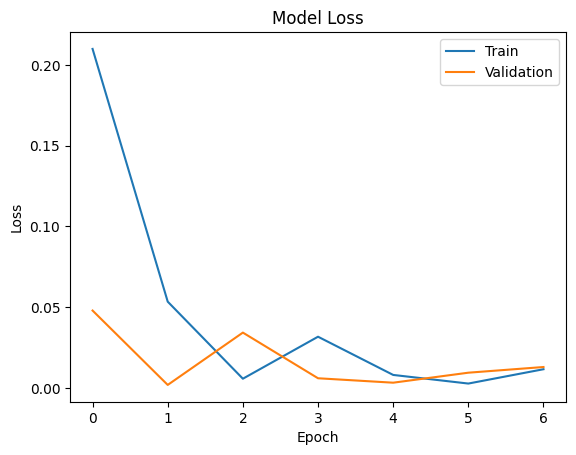

In [ ]:
# Plot training & validation loss values
plt.plot(history3_lstm.history['loss'])
plt.plot(history3_lstm.history['val_loss'])
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(['Train', 'Validation'], loc='upper right')
plt.show()

In [ ]:
# Predict for 12 month afterwards
n_past3_lstm = 1
n_month_for_prediction3_lstm = 12
predict_period_month3_lstm = pd.date_range(list(train_datetime)[-n_past], periods=n_month_for_prediction3_lstm, freq='M').tolist()
print(predict_period_month3_lstm)

[Timestamp('2022-12-31 00:00:00', freq='M'), Timestamp('2023-01-31 00:00:00', freq='M'), Timestamp('2023-02-28 00:00:00', freq='M'), Timestamp('2023-03-31 00:00:00', freq='M'), Timestamp('2023-04-30 00:00:00', freq='M'), Timestamp('2023-05-31 00:00:00', freq='M'), Timestamp('2023-06-30 00:00:00', freq='M'), Timestamp('2023-07-31 00:00:00', freq='M'), Timestamp('2023-08-31 00:00:00', freq='M'), Timestamp('2023-09-30 00:00:00', freq='M'), Timestamp('2023-10-31 00:00:00', freq='M'), Timestamp('2023-11-30 00:00:00', freq='M')]


In [ ]:
# Print the error metrics

prediction3_lstm = model.predict(train_x3_lstm[-n_month_for_prediction:])
mse3_lstm = mean_squared_error(train_y3_lstm[-n_month_for_prediction:], prediction3_lstm)
fmape = np.mean(np.abs((mse3_lstm) / prediction3_lstm)) * 100
mape3_lstm = f"{(fmape*100):.2f}%"
mae3_lstm = np.mean(np.abs((mse) / prediction3_lstm))
r2_3_lstm = r2_score(train_y3_lstm[-n_month_for_prediction:], prediction3_lstm)
print("MSE:", mse3_lstm)
print("MAPE:", mape3_lstm)
print("MAE:", mae3_lstm)
print("r-scores:", r2_3_lstm)


1/1 [==============================] - 0s 30ms/step
MSE: 0.0002794061661478109
MAPE: 5.33%
MAE: 0.00032931528
r-scores: 0.9957589620271706


In [ ]:
prediction_copies3_lstm = np.repeat(prediction3_lstm, data_for_training.shape[1], axis=-1)
y_pred_future3_lstm = scaler.inverse_transform(prediction_copies3_lstm)[:,0]

<ipython-input-72-50b929cb3467>:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  original['datetime'] = pd.to_datetime(original['datetime'])


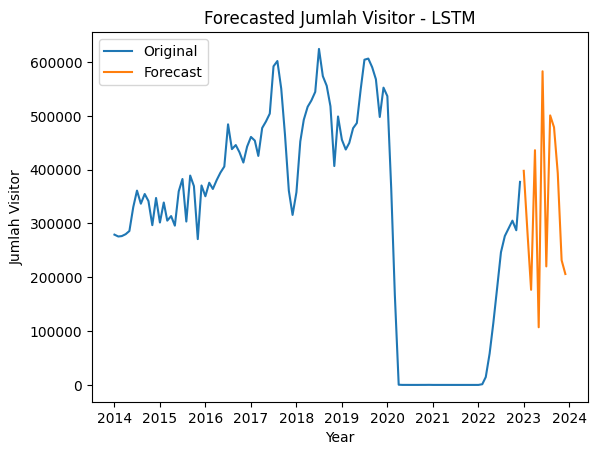

╒═════════════════════╤══════════════╕
│ Date                │   Prediction │
╞═════════════════════╪══════════════╡
│ 2023-01-01 00:00:00 │     524505   │
├─────────────────────┼──────────────┤
│ 2023-02-01 00:00:00 │     589882   │
├─────────────────────┼──────────────┤
│ 2023-03-01 00:00:00 │     272408   │
├─────────────────────┼──────────────┤
│ 2023-04-01 00:00:00 │     107134   │
├─────────────────────┼──────────────┤
│ 2023-05-01 00:00:00 │     265824   │
├─────────────────────┼──────────────┤
│ 2023-06-01 00:00:00 │     339114   │
├─────────────────────┼──────────────┤
│ 2023-07-01 00:00:00 │     112798   │
├─────────────────────┼──────────────┤
│ 2023-08-01 00:00:00 │      64262.7 │
├─────────────────────┼──────────────┤
│ 2023-09-01 00:00:00 │     388266   │
├─────────────────────┼──────────────┤
│ 2023-10-01 00:00:00 │      74023.2 │
├─────────────────────┼──────────────┤
│ 2023-11-01 00:00:00 │     529463   │
├─────────────────────┼──────────────┤
│ 2023-12-01 00:00:00 │  

In [ ]:
forecast_dates3_lstm = []

for time_i in predict_period_month:
    forecast_dates3_lstm.append(time_i.date())

df_forecast3_lstm = pd.DataFrame({'Date': forecast_dates3_lstm, 'total_visitor': y_pred_future3_lstm})
df_forecast3_lstm['Date'] = pd.to_datetime(df_forecast3_lstm['Date'])

# Assuming 'original' contains the original data with 'datetime' and 'total_visitor' columns
original = data_real[['datetime', 'total_visitor']]
original['datetime'] = pd.to_datetime(original['datetime'])
original = original.loc[original['datetime'] >= '2014-01-01']

sns.lineplot(data=original, x='datetime', y='total_visitor', label='Original')
sns.lineplot(data=df_forecast, x='Date', y='total_visitor', label='Forecast')

plt.xlabel('Year')
plt.ylabel('Jumlah Visitor')
plt.title('Forecasted Jumlah Visitor - LSTM')
plt.legend()
plt.show()

# Generate the forecast dates from January 2023 to December 2023
forecast_dates3_lstm = pd.date_range(start='2023-01-01', end='2023-12-01', freq='MS')

# Create a list of forecast dates and prediction values
data = list(zip(forecast_dates3_lstm, y_pred_future3_lstm))

# Create a list of headers for the table
headers = ['Date', 'Prediction']
table3_lstm = tabulate(data, headers=headers, tablefmt='fancy_grid')
# Print the table
print(table2_lstm)

###Conclusion

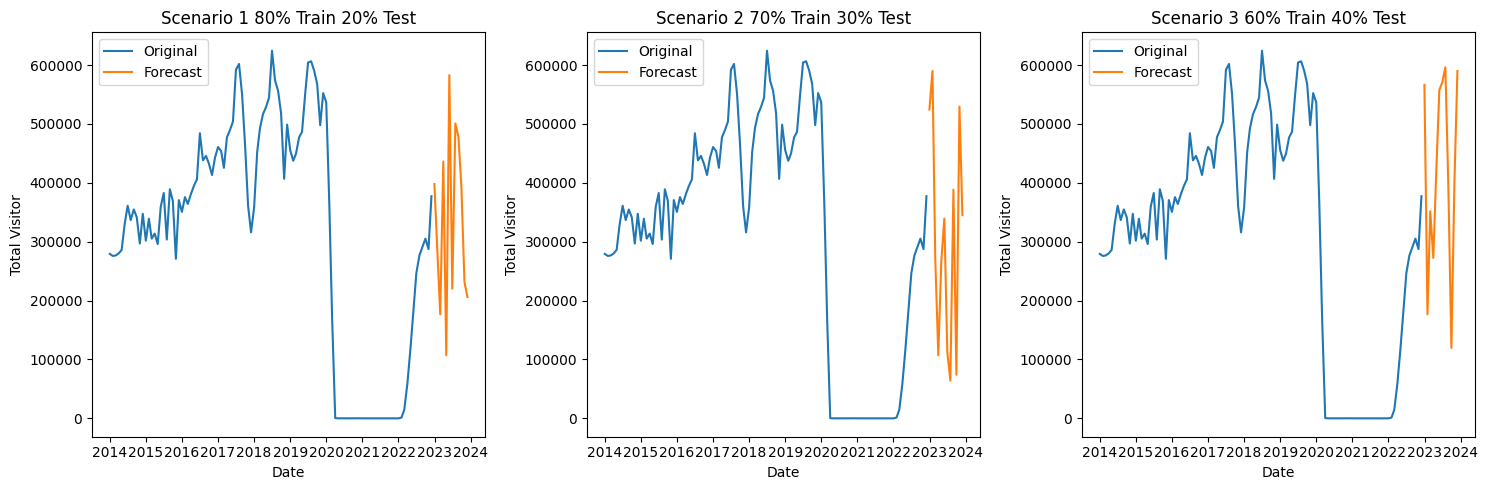

╒════════════╤═════════╤═════════════╤═════════════╤════════╕
│ Scenario   │ Model   │         MAE │         MSE │ MAPE   │
╞════════════╪═════════╪═════════════╪═════════════╪════════╡
│ Scenario 1 │ LTSM    │ 0.000408135 │ 0.000172655 │ 4.08%  │
├────────────┼─────────┼─────────────┼─────────────┼────────┤
│ Scenario 2 │ LTSM    │ 0.000644185 │ 0.000180439 │ 6.44%  │
├────────────┼─────────┼─────────────┼─────────────┼────────┤
│ Scenario 3 │ LTSM    │ 0.000329315 │ 0.000279406 │ 5.33%  │
╘════════════╧═════════╧═════════════╧═════════════╧════════╛


In [ ]:
plt.figure(figsize=(15, 5))

# Scenario 1
plt.subplot(1, 3, 1)
sns.lineplot(data=original, x='datetime', y='total_visitor', label='Original')
sns.lineplot(data=df_forecast, x='Date', y='total_visitor', label='Forecast')
plt.xlabel('Date')
plt.ylabel('Total Visitor')
plt.title('Scenario 1 80% Train 20% Test')
plt.legend()

# Scenario 2
plt.subplot(1, 3, 2)
sns.lineplot(data=original, x='datetime', y='total_visitor', label='Original')
sns.lineplot(data=df_forecast2_lstm, x='Date', y='total_visitor', label='Forecast')
plt.xlabel('Date')
plt.ylabel('Total Visitor')
plt.title('Scenario 2 70% Train 30% Test')
plt.legend()

# Scenario 3
plt.subplot(1, 3, 3)
sns.lineplot(data=original, x='datetime', y='total_visitor', label='Original')
sns.lineplot(data=df_forecast3_lstm , x='Date', y='total_visitor', label='Forecast')
plt.xlabel('Date')
plt.ylabel('Total Visitor')
plt.title('Scenario 3 60% Train 40% Test')
plt.legend()

plt.tight_layout()
plt.show()

# Define the data for each scenario
scenario_data = [
    {
        'Scenario': 'Scenario 1',
        'Model': 'LTSM',
        'MAE': mae,
        'MSE': mse,
        'MAPE': mape
    },
    {
        'Scenario': 'Scenario 2',
        'Model': 'LTSM',
        'MAE': mae2_lstm,
        'MSE': mse2_lstm,
        'MAPE': mape2_lstm
    },
    {
        'Scenario': 'Scenario 3',
        'Model': 'LTSM',
        'MAE': mae3_lstm,
        'MSE': mse3_lstm,
        'MAPE': mape3_lstm
    }
]

# Create a DataFrame from the scenario data
df = pd.DataFrame(scenario_data)

# Convert DataFrame to a list of rows
rows = df.values.tolist()

# Create a list of headers
headers = df.columns.tolist()

# Generate the table
table4 = tabulate(rows, headers=headers, tablefmt='fancy_grid')

# Print the table
print(table4)